In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras import Sequential

2024-02-01 21:03:44.872527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 21:03:44.872607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 21:03:44.933931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 21:03:45.079144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 21:03:46.959993: W tensorflow/compiler/tf2

In [9]:
dataset="dataset"
img_height,img_width=224,224
batch_size=32

classes=os.listdir(dataset)
print(classes)

n=len(classes)

# all the images and their corresponding labels
plant_images=[]
labels=[]

for plant in classes:
    images=os.path.join(dataset,plant)
    for image in os.listdir(images):
        plant_images.append(os.path.join(images,image))
        labels.append(plant)

print(plant_images)
print(labels)

['aloevera_leaf', 'arali_leaf', 'ashoka_leaf', 'bamboo_leaf', 'betel_leaf', 'camphor_leaf', 'coffee_leaf', 'drumstick_leaf', 'eucalyptus_leaf', 'ginger_leaf', 'guava_leaf', 'henna_leaf', 'hibiscus_leaf', 'jackfruit_leaf', 'jasmine_leaf', 'lantana_leaf', 'lemon_leaf', 'malabar_nut_leaf', 'mango_leaf', 'mint_leaf', 'neem_leaf', 'papaya_leaf', 'pumpkin_leaf', 'rose_leaf', 'sapota_leaf', 'tamarind_leaf', 'tomato_leaf', 'tulsi_leaf', 'turmeric_leaf']
['dataset/aloevera_leaf/10.png', 'dataset/aloevera_leaf/100.png', 'dataset/aloevera_leaf/102.png', 'dataset/aloevera_leaf/106.png', 'dataset/aloevera_leaf/108.png', 'dataset/aloevera_leaf/110.png', 'dataset/aloevera_leaf/112.png', 'dataset/aloevera_leaf/114.png', 'dataset/aloevera_leaf/116.png', 'dataset/aloevera_leaf/118.png', 'dataset/aloevera_leaf/12.png', 'dataset/aloevera_leaf/128.png', 'dataset/aloevera_leaf/132.png', 'dataset/aloevera_leaf/136.png', 'dataset/aloevera_leaf/138.png', 'dataset/aloevera_leaf/14.png', 'dataset/aloevera_leaf/1

In [12]:
x_train,x_test,y_train,y_test=train_test_split(plant_images,labels,test_size=0.3,random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Create DataFrames for training, validation, and testing
train_data = pd.DataFrame({"plant_images": x_train, "labels": y_train})
val_data = pd.DataFrame({"plant_images": x_val, "labels": y_val})
test_data = pd.DataFrame({"plant_images": x_test, "labels": y_test})


In [13]:
train_aug=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_aug=ImageDataGenerator(
    rescale=1./255
)
val_aug=ImageDataGenerator(
    rescale=1./255
)

train_gen=train_aug.flow_from_dataframe(
    train_data,
    x_col="plant_images",
    y_col="labels",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_gen=test_aug.flow_from_dataframe(
    test_data,
    x_col="plant_images",
    y_col="labels",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen=val_aug.flow_from_dataframe(
    val_data,
    x_col="plant_images",
    y_col="labels",
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1706 validated image filenames belonging to 29 classes.
Found 366 validated image filenames belonging to 29 classes.
Found 366 validated image filenames belonging to 29 classes.


In [15]:
feature_ext_model= "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2"

pretrained_mod =hub.KerasLayer(
    feature_ext_model, input_shape=(img_height, img_width, 3), trainable=False
)

model=tf.keras.Sequential([
    pretrained_mod,
    Dropout(0.3),
    Dense(n,activation="softmax")
])

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              20331360  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 29)                37149     
                                                                 
Total params: 20368509 (77.70 MB)
Trainable params: 37149 (145.11 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [16]:
history=model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
)
model.save("AyurBotClassEf.h5")

Epoch 1/10
54/54 [==============================] - 160s 2s/step - loss: 2.3635 - accuracy: 0.3529 - val_loss: 1.0978 - val_accuracy: 0.7131
Epoch 2/10
54/54 [==============================] - 127s 2s/step - loss: 0.9585 - accuracy: 0.7263 - val_loss: 0.6360 - val_accuracy: 0.8716
Epoch 3/10
54/54 [==============================] - 125s 2s/step - loss: 0.5983 - accuracy: 0.8335 - val_loss: 0.4758 - val_accuracy: 0.8798
Epoch 4/10
54/54 [==============================] - 124s 2s/step - loss: 0.4456 - accuracy: 0.8781 - val_loss: 0.3752 - val_accuracy: 0.9235
Epoch 5/10
54/54 [==============================] - 124s 2s/step - loss: 0.3770 - accuracy: 0.8986 - val_loss: 0.3176 - val_accuracy: 0.9208
Epoch 6/10
54/54 [==============================] - 128s 2s/step - loss: 0.3153 - accuracy: 0.9185 - val_loss: 0.2684 - val_accuracy: 0.9344
Epoch 7/10
54/54 [==============================] - 128s 2s/step - loss: 0.2535 - accuracy: 0.9414 - val_loss: 0.2564 - val_accuracy: 0.9344
Epoch 8/10
54

/home/satya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


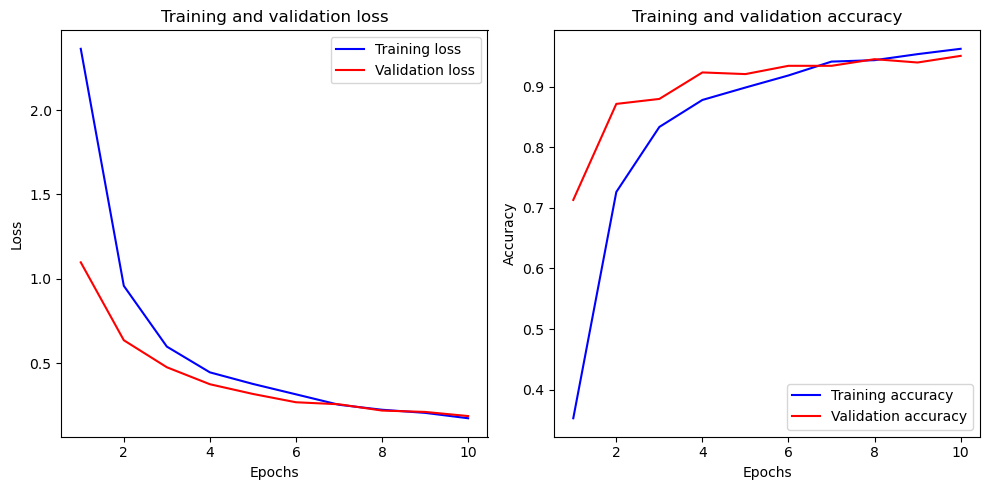

In [17]:
import matplotlib.pyplot as plt

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# modelTry = tf.keras.models.load_model("AyurBotClassEf.h5")
modelTry=model
test_loss, test_accuracy = modelTry.evaluate(test_gen)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 26s 2s/step - loss: 0.1509 - accuracy: 0.9672
Test Loss: 0.15086482465267181
Test Accuracy: 0.9672130942344666


In [23]:
label_ind={}
for i in range(n):
    label_ind[i]=classes[i]

In [61]:
from tensorflow.keras.preprocessing import image

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_height,img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0 
    return img_array

def predict_on_custom_image(image_path):
    img_array = preprocess_image(image_path)
    predictions = modelTry.predict(img_array)
    predList=predictions.tolist()
    # print(predList)
    l=[]
    for i in range(n):
        temp=[predList[0][i],label_ind[i]]
        l.append(temp)
    l.sort()
    l.reverse()
    ans=[]
    for i in range(5):
        ans.append(l[i])
    predicted_class = np.argmax(predictions, axis=1)
    return ans

In [62]:
custom_image_path = "custom_testing/aloe.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 42ms/step
[0.5644857287406921, 'eucalyptus_leaf']
[0.14667567610740662, 'aloevera_leaf']
[0.06097668409347534, 'papaya_leaf']
[0.04745587706565857, 'bamboo_leaf']
[0.02774016186594963, 'ginger_leaf']


In [63]:
custom_image_path = "custom_testing/arali.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 37ms/step
[0.408314973115921, 'jackfruit_leaf']
[0.25580286979675293, 'betel_leaf']
[0.20603151619434357, 'henna_leaf']
[0.044443096965551376, 'hibiscus_leaf']
[0.012846111319959164, 'jasmine_leaf']


In [64]:
custom_image_path = "custom_testing/ashoka.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 38ms/step
[0.43259748816490173, 'ashoka_leaf']
[0.2622157335281372, 'eucalyptus_leaf']
[0.1585579812526703, 'aloevera_leaf']
[0.07976439595222473, 'neem_leaf']
[0.028309915214776993, 'coffee_leaf']


In [65]:
custom_image_path = "custom_testing/bam.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 38ms/step
[0.324985533952713, 'bamboo_leaf']
[0.2702055871486664, 'turmeric_leaf']
[0.253060907125473, 'sapota_leaf']
[0.08834458142518997, 'betel_leaf']
[0.0278477780520916, 'tulsi_leaf']


In [66]:
custom_image_path = "custom_testing/betel.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 38ms/step
[0.9809539318084717, 'betel_leaf']
[0.015462358482182026, 'hibiscus_leaf']
[0.0014098763931542635, 'tulsi_leaf']
[0.0009677900234237313, 'jackfruit_leaf']
[0.00027259791386313736, 'henna_leaf']


In [67]:
custom_image_path = "custom_testing/coff.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 36ms/step
[0.41069096326828003, 'coffee_leaf']
[0.11955166608095169, 'henna_leaf']
[0.07288229465484619, 'papaya_leaf']
[0.06077645346522331, 'hibiscus_leaf']
[0.05809859186410904, 'jackfruit_leaf']


In [71]:
custom_image_path = "custom_testing/drum.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 37ms/step
[0.5865517258644104, 'tulsi_leaf']
[0.08497830480337143, 'tomato_leaf']
[0.05893959105014801, 'papaya_leaf']
[0.04916226491332054, 'mint_leaf']
[0.029515543952584267, 'pumpkin_leaf']


In [72]:
custom_image_path = "custom_testing/euca.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 39ms/step
[0.8856899738311768, 'eucalyptus_leaf']
[0.05225035548210144, 'neem_leaf']
[0.024965379387140274, 'sapota_leaf']
[0.01195624377578497, 'papaya_leaf']
[0.007040439639240503, 'mango_leaf']


In [74]:
custom_image_path = "custom_testing/ging.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 38ms/step
[0.17868290841579437, 'ginger_leaf']
[0.1347731202840805, 'mango_leaf']
[0.10386016964912415, 'aloevera_leaf']
[0.0993536189198494, 'ashoka_leaf']
[0.09257764369249344, 'bamboo_leaf']


In [76]:
custom_image_path = "custom_testing/gua.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 38ms/step
[0.45086869597435, 'jackfruit_leaf']
[0.15897364914417267, 'guava_leaf']
[0.08299141377210617, 'neem_leaf']
[0.07955082505941391, 'aloevera_leaf']
[0.056154701858758926, 'rose_leaf']


In [79]:
custom_image_path = "custom_testing/henna.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 40ms/step
[0.580513060092926, 'tulsi_leaf']
[0.11875829100608826, 'jackfruit_leaf']
[0.08268456906080246, 'sapota_leaf']
[0.06845761835575104, 'henna_leaf']
[0.02509712614119053, 'neem_leaf']


In [85]:
custom_image_path = "custom_testing/hibus.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 43ms/step
[0.3810165822505951, 'hibiscus_leaf']
[0.28831490874290466, 'lantana_leaf']
[0.24879124760627747, 'pumpkin_leaf']
[0.037772126495838165, 'tulsi_leaf']
[0.024229729548096657, 'betel_leaf']


In [86]:
custom_image_path = "custom_testing/jack.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 48ms/step
[0.753841757774353, 'jackfruit_leaf']
[0.095731221139431, 'henna_leaf']
[0.03802638500928879, 'camphor_leaf']
[0.02407214231789112, 'betel_leaf']
[0.02402002364397049, 'hibiscus_leaf']


In [94]:
custom_image_path = "custom_testing/jas.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 44ms/step
[0.6095029711723328, 'henna_leaf']
[0.11182089149951935, 'hibiscus_leaf']
[0.10763382911682129, 'malabar_nut_leaf']
[0.07222913950681686, 'jackfruit_leaf']
[0.031339917331933975, 'jasmine_leaf']


In [95]:
custom_image_path = "custom_testing/lan.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 40ms/step
[0.4247596859931946, 'lantana_leaf']
[0.296196311712265, 'tulsi_leaf']
[0.1323353499174118, 'mint_leaf']
[0.038838259875774384, 'henna_leaf']
[0.026035631075501442, 'hibiscus_leaf']


In [100]:
custom_image_path = "custom_testing/lem.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 47ms/step
[0.28577709197998047, 'jackfruit_leaf']
[0.25790682435035706, 'lemon_leaf']
[0.16116923093795776, 'coffee_leaf']
[0.15085864067077637, 'henna_leaf']
[0.02884591743350029, 'jasmine_leaf']


In [102]:
custom_image_path = "custom_testing/man.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 58ms/step
[0.475104421377182, 'coffee_leaf']
[0.15866196155548096, 'guava_leaf']
[0.12044259905815125, 'mango_leaf']
[0.10620910674333572, 'neem_leaf']
[0.043417610228061676, 'jackfruit_leaf']


In [103]:
custom_image_path = "custom_testing/min.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 189ms/step
[0.6657032370567322, 'tulsi_leaf']
[0.21079804003238678, 'mint_leaf']
[0.0655922070145607, 'pumpkin_leaf']
[0.03538714349269867, 'lantana_leaf']
[0.009835130535066128, 'hibiscus_leaf']


In [104]:
custom_image_path = "custom_testing/neem.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 48ms/step
[0.45953255891799927, 'jackfruit_leaf']
[0.436677485704422, 'neem_leaf']
[0.03536773845553398, 'coffee_leaf']
[0.027199190109968185, 'eucalyptus_leaf']
[0.006662334781140089, 'henna_leaf']


In [105]:
custom_image_path = "custom_testing/pap.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 48ms/step
[0.9690064191818237, 'papaya_leaf']
[0.01290829200297594, 'sapota_leaf']
[0.004122880287468433, 'tomato_leaf']
[0.0034759033005684614, 'henna_leaf']
[0.0016310987994074821, 'jackfruit_leaf']


In [107]:
custom_image_path = "custom_testing/pump.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 69ms/step
[0.9587986469268799, 'pumpkin_leaf']
[0.025956101715564728, 'betel_leaf']
[0.005460374057292938, 'arali_leaf']
[0.003701844485476613, 'hibiscus_leaf']
[0.0018851635977625847, 'mint_leaf']


In [109]:
custom_image_path = "custom_testing/rose.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 39ms/step
[0.6546277403831482, 'tulsi_leaf']
[0.08410333096981049, 'rose_leaf']
[0.07345700263977051, 'lantana_leaf']
[0.0322645865380764, 'mint_leaf']
[0.030006228014826775, 'sapota_leaf']


In [110]:
custom_image_path = "custom_testing/sap.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 40ms/step
[0.4466697871685028, 'sapota_leaf']
[0.19499391317367554, 'guava_leaf']
[0.14103339612483978, 'jackfruit_leaf']
[0.04847320169210434, 'henna_leaf']
[0.03917233273386955, 'rose_leaf']


In [111]:
custom_image_path = "custom_testing/tam.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 44ms/step
[0.24547673761844635, 'neem_leaf']
[0.1463247686624527, 'tamarind_leaf']
[0.1084829643368721, 'eucalyptus_leaf']
[0.06875374913215637, 'aloevera_leaf']
[0.052074942737817764, 'mango_leaf']


In [117]:
custom_image_path = "custom_testing/tom.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 49ms/step
[0.513530433177948, 'papaya_leaf']
[0.22214914858341217, 'tomato_leaf']
[0.10969673097133636, 'neem_leaf']
[0.055001165717840195, 'tulsi_leaf']
[0.040616173297166824, 'lantana_leaf']


In [120]:
custom_image_path = "custom_testing/tul.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 50ms/step
[0.5432732105255127, 'tulsi_leaf']
[0.38572144508361816, 'lantana_leaf']
[0.030317779630422592, 'hibiscus_leaf']
[0.018990369513630867, 'henna_leaf']
[0.005378517787903547, 'mint_leaf']


In [121]:
custom_image_path = "custom_testing/tur.jpeg"
predicted_classes = predict_on_custom_image(custom_image_path)
for x in predicted_classes:
    print(x)

1/1 [==============================] - 0s 40ms/step
[0.2521724998950958, 'turmeric_leaf']
[0.179984912276268, 'jackfruit_leaf']
[0.11988995969295502, 'mango_leaf']
[0.09335372596979141, 'ginger_leaf']
[0.07764123380184174, 'malabar_nut_leaf']
